In [1]:
from __future__ import print_function
import argparse
import pickle

import numpy as np
import torch
from captum.attr import IntegratedGradients

import cbig.osama2024.misc as misc

f:\Professional\Thesis\RNN-AD\RNN_py3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### IG

In [2]:
checkpoint_path = 'output/model.pt'
data_path = 'output/val.pkl'

device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load(checkpoint_path)
model.to(device)

with open(data_path, 'rb') as fhandler:
    data = pickle.load(fhandler)

In [3]:
integrated_gradients = IntegratedGradients(model)

In [4]:
test_data = data['test']
pred_start = data['pred_start']
duration = data['duration']
baseline = data['baseline']

### IG for a specific duration and target class (CN:0, MCI:1, AD:2)

In [ ]:


duration = 20
target_index_2 = 0

model.eval()
ret = {'subjects': test_data.subjects}
ret['DX'] = []  # 1. likelihood of NL, MCI, and Dementia
ret['ADAS13'] = []  # 2. (best guess, upper and lower bounds on 50% CI)
ret['Ventricles'] = []  # 3. (best guess, upper and lower bounds on 50% CI)
ret['dates'] = misc.make_date_col(
    [pred_start[s] for s in test_data.subjects], duration)

col = ['ADAS13', 'Ventricles', 'ICV']
indices = misc.get_index(list(test_data.value_fields()), col)
mean = model.mean[col].values.reshape(1, -1)
stds = model.stds[col].values.reshape(1, -1)

attributions = {}
    
for i in range(len(test_data)):
    data_entry = test_data[i]
    rid = data_entry['rid']
    all_tp = data_entry['tp'].squeeze(axis=1)
    start = misc.month_between(pred_start[rid], baseline[rid])
    assert np.all(all_tp == np.arange(len(all_tp)))
    mask = all_tp < start
    itime = np.arange(start + duration)
    icat = np.asarray(
        [misc.to_categorical(c, 3) for c in data_entry['cat'][mask]])
    ival = data_entry['val'][:, None, :][mask]
    
    in_val = np.full((len(itime), ) + ival.shape[1:], np.nan)
    in_val[:len(ival)] = ival
    
    in_cat = np.full((len(itime), ) + icat.shape[1:], np.nan)
    in_cat[:len(icat)] = icat
    
    input_val = torch.tensor(in_val, dtype=torch.float32).to(device)
    input_cat = torch.tensor(in_cat, dtype=torch.float32).to(device)
    # input_val = in_val
    # input_cat = in_cat
    
    # target = (0,0,0,0)
    # # convert to tensor
    # target_tensor = torch.tensor(target, dtype=torch.float32).to(device)
    
    attr_cat = integrated_gradients.attribute(
        inputs=(input_cat, input_val), 
        baselines=None,  # You can provide baselines if needed
        target=(0,target_index_2)  # You can specify the target output index if needed
    )
    
    # Save attributions
    attributions[rid] = {
        'cat': attr_cat
    }
    
    # ocat, oval = predict_subject(model, icat, ival, itime)


### IG for durations 40,60,80

In [39]:
durations = [12, 24, 36]
categories = [0, 1, 2]

for duration in durations:
    print(f"Duration: {duration}")
    for c in categories:
        print(f"Category: {c}")
        target_index_2 = c
        
        model.eval()
        ret = {'subjects': test_data.subjects}
        ret['DX'] = []  # 1. likelihood of NL, MCI, and Dementia
        ret['ADAS13'] = []  # 2. (best guess, upper and lower bounds on 50% CI)
        ret['Ventricles'] = []  # 3. (best guess, upper and lower bounds on 50% CI)
        ret['dates'] = misc.make_date_col(
            [pred_start[s] for s in test_data.subjects], duration)

        col = ['ADAS13', 'Ventricles', 'ICV']
        indices = misc.get_index(list(test_data.value_fields()), col)
        mean = model.mean[col].values.reshape(1, -1)
        stds = model.stds[col].values.reshape(1, -1)
        
        
        attributions = {}
    
        for i in range(len(test_data)):
            data_entry = test_data[i]
            rid = data_entry['rid']
            all_tp = data_entry['tp'].squeeze(axis=1)
            start = misc.month_between(pred_start[rid], baseline[rid])
            assert np.all(all_tp == np.arange(len(all_tp)))
            mask = all_tp < start
            itime = np.arange(start + duration)
            icat = np.asarray(
                [misc.to_categorical(c, 3) for c in data_entry['cat'][mask]])
            ival = data_entry['val'][:, None, :][mask]
            
            in_val = np.full((len(itime), ) + ival.shape[1:], np.nan)
            in_val[:len(ival)] = ival
            
            in_cat = np.full((len(itime), ) + icat.shape[1:], np.nan)
            in_cat[:len(icat)] = icat
            
            input_val = torch.tensor(in_val, dtype=torch.float32).to(device)
            input_cat = torch.tensor(in_cat, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                out_cat = model(input_cat, input_val)
        
            out_cat = out_cat.cpu().numpy()
            ret['DX'].append(out_cat[-duration:, 0, :])
            
            # target = (0,0,0,0)
            # # convert to tensor
            # target_tensor = torch.tensor(target, dtype=torch.float32).to(device)
            
            attr_cat = integrated_gradients.attribute(
                inputs=(input_cat, input_val), 
                baselines=None,  # You can provide baselines if needed
                target=(0,target_index_2)  # You can specify the target output index if needed
            )
            
            # Save attributions
            attributions[rid] = {
                'cat': attr_cat
            }
            
            my_dict = attributions

        #save the attributions
        with open(f'MyData_42_feat/attr2/attributions_{duration}_{target_index_2}.pickle', 'wb') as pickle_file:
            pickle.dump(my_dict, pickle_file)
        
        #save the ret
        with open(f'MyData_42_feat/ret2/ret_{duration}_{target_index_2}.pickle', 'wb') as pickle_file:
            pickle.dump(ret, pickle_file)
            
        
        

Duration: 12
Category: 0
Category: 1
Category: 2
Duration: 24
Category: 0
Category: 1
Category: 2
Duration: 36
Category: 0
Category: 1
Category: 2


### Grouping

Here we divide the patients according to their final predicted classes. So there can not be more than 3 divisions. At the same time attributions are divided into 3 groups as well

In [5]:
def divide_data_by_max_probability(ret, attributions, day):
    # Initialize
    divided_ret = {i: [] for i in range(ret['DX'][0].shape[1])}
    divided_attributions = {i: [] for i in range(ret['DX'][0].shape[1])}

    for patient_index in range(len(ret['DX'])):
        # Get the diagnosis probabilities for the specified day for the current patient
        probabilities = ret['DX'][patient_index][day - 1]

        # Find the index of the diagnosis class with the maximum probability for this day
        max_index = np.argmax(probabilities)

        # Append the current patient's data to the corresponding divided part for ret
        divided_ret[max_index].append({
            'patient_index': patient_index,
            'diagnosis_probabilities': probabilities
        })

        # Append the corresponding attribution data
        attribution_key = list(attributions.keys())[patient_index]
        divided_attributions[max_index].append({
            'patient_index': patient_index,
            'attribution_data': attributions[attribution_key]
        })

    return divided_ret, divided_attributions



### Loading Attributions

In [40]:
import pickle 

loaded_duration = 24
loaded_target_index_2 = 2

# load ret
with open(f'MyData_42_feat/ret2/ret_{loaded_duration}_{loaded_target_index_2}.pickle', 'rb') as pickle_file:
    ret = pickle.load(pickle_file)
    
with open(f'MyData_42_feat/attr2/attributions_{loaded_duration}_{loaded_target_index_2}.pickle', 'rb') as pickle_file:
    my_dict = pickle.load(pickle_file)
    
attributions = my_dict
# Example usage
day = loaded_duration
divided_ret, divided_attributions = divide_data_by_max_probability(ret, attributions, day)

# Print the lengths of divided parts for ret
for class_index, data_list in divided_ret.items():
    print(f"Class {class_index}: {len(data_list)} patients")

# Print the lengths of divided parts for attributions
for class_index, data_list in divided_attributions.items():
    print(f"Class {class_index}: {len(data_list)} attributions")

Class 0: 55 patients
Class 1: 56 patients
Class 2: 48 patients
Class 0: 55 attributions
Class 1: 56 attributions
Class 2: 48 attributions


### Index Description: 
divided_attributions [which class out of 3] [which patient of that class] ['attribution_data']['cat'][either feature attributions (0) or diagnosis attributions (1)] [which timepoint (duration)]

In [7]:
print(divided_attributions[1][6]['attribution_data']['cat'][0][0])

# convert to numpy
np_attributions = np.array(divided_attributions[1][0]['attribution_data']['cat'][1][0][0])


tensor([[ 0.0000, -0.0704,  0.0000]], dtype=torch.float64)


In [8]:
np_attributions.shape

(38,)

### Plot for DX attributions

In [9]:
import matplotlib.pyplot as plt

def plot_dx_attributions(dx_index, num_patients, class_index, 
                              divided_attributions, dx_name, isShow=True):
    # Extract attributions for the specified class index and feature index
    attributions = divided_attributions[class_index]

    if num_patients == -1:
        num_patients = len(attributions)

    # Extract the feature attributions for the specified feature index
    feature_attributions = [attribution['attribution_data']['cat'][0][0][0][dx_index].numpy() for attribution in attributions[:num_patients]]

    feature_mean = np.mean(feature_attributions)
    feature_std = np.std(feature_attributions)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    for i, attribution in enumerate(feature_attributions):
        plt.bar(i, attribution, color='blue')
    plt.xlabel('Patient Index')
    plt.ylabel(f'Attribution for DX class {dx_index}: {dx_name}')
    plt.title(f'Attributions for DX{dx_index}: {dx_name} of Class {class_index} for {num_patients} Patients')
    
    if isShow:
        plt.show()
    
    plt.savefig(f'MyData_42_feat/plots/{loaded_duration}/target_{loaded_target_index_2}/attr_C{class_index}_DX{dx_index}_{dx_name}.png')
    
    return feature_mean, feature_std


def plot_dx_attributions_all(dx_index, num_patients, class_index, 
                              divided_attributions, dx_name, isShow=True):
    # Extract attributions for the specified class index and feature index
    attributions0 = divided_attributions[0]
    attributions1 = divided_attributions[1]
    attributions2 = divided_attributions[2]
    
    #concat 3 lists
    attributions = attributions0 + attributions1 + attributions2

    if num_patients == -1:
        num_patients = len(attributions)

    # Extract the feature attributions for the specified feature index
    feature_attributions = [attribution['attribution_data']['cat'][0][0][0][dx_index].numpy() for attribution in attributions[:num_patients]]

    feature_mean = np.mean(feature_attributions)
    feature_std = np.std(feature_attributions)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    for i, attribution in enumerate(feature_attributions):
        plt.bar(i, attribution, color='blue')
    plt.xlabel('Patient Index')
    plt.ylabel(f'Attribution for DX Class {dx_index}: {dx_name}')
    plt.title(f'Attributions for DX{dx_index}: {dx_name} of Class {class_index} for {num_patients} Patients')
    
    if isShow:
        plt.show()
        
    #save fig
    plt.savefig(f'MyData_42_feat/plots/{loaded_duration}/target_{loaded_target_index_2}/attr_all_DX{dx_index}_{dx_name}.png')
    
    return feature_mean, feature_std


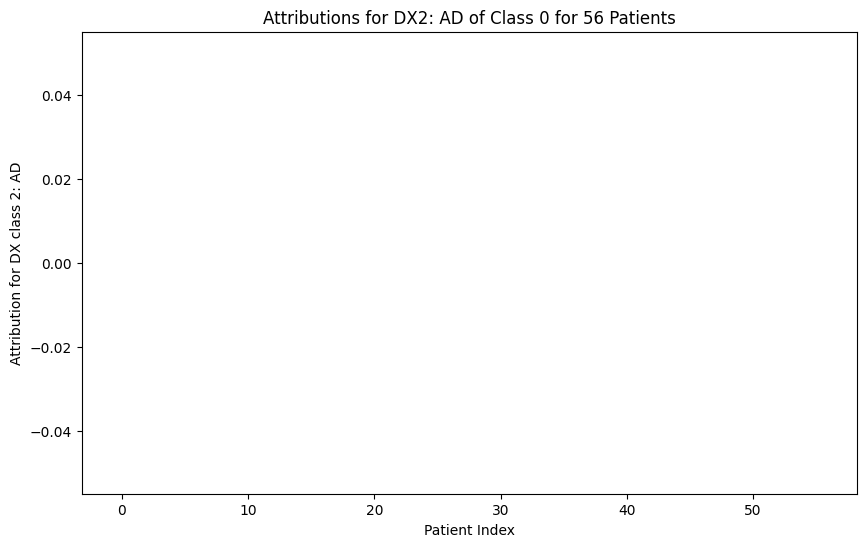

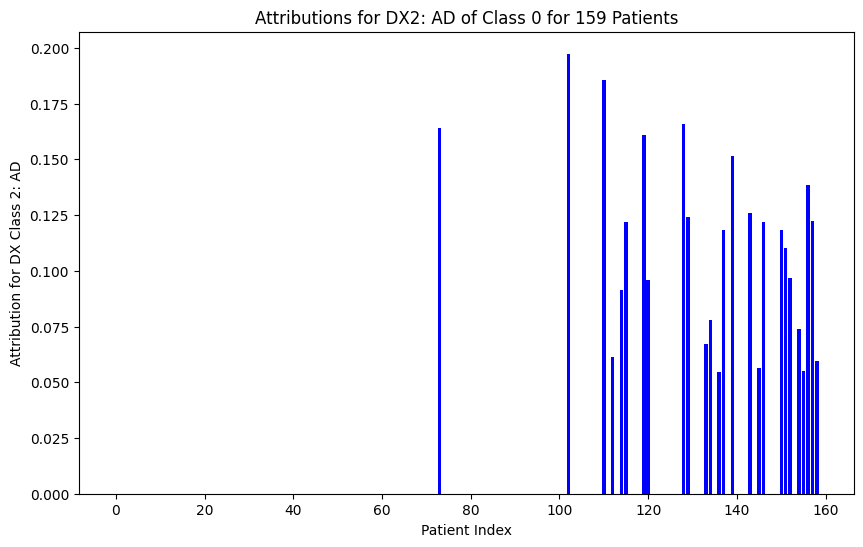

In [10]:
# Example usage
dx_index = 2  # Change this to the desired feature index
num_patients = -1  # Change this to -1 to include all patients, otherwise specify a number
class_index = 0  # Change this to the desired class index

dx_name = ''
# set dx_name to CN if 0, MCI if 1, AD if 2
if dx_index == 0:
    dx_name = 'CN'
elif dx_index == 1:
    dx_name = 'MCI'
elif dx_index == 2:
    dx_name = 'AD'

feature_mean, feature_std = \
    plot_dx_attributions(dx_index, num_patients, \
        class_index, divided_attributions, dx_name, False)

feature_mean, feature_std = \
    plot_dx_attributions_all(dx_index, num_patients, \
        class_index, divided_attributions, dx_name, False)


### Plot attributions
parameters:
* feature_index = which feature to focus on
* num_patient = count of patients. -1 means all from that group
* class_index = select the attribution group. 

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_box(divided_attributions, feature_names, colors, specific_class=-1):
    attributions0 = divided_attributions[0]
    attributions1 = divided_attributions[1]
    attributions2 = divided_attributions[2]
    
    total = attributions0 + attributions1 + attributions2
    
    num_patients0 = len(attributions0)
    num_patients1 = len(attributions1)
    num_patients2 = len(attributions2)
    
    total_patients = num_patients0 + num_patients1 + num_patients2
    
    num_features = len(feature_names)
        
    # Initialize lists to store feature attributions for each class
    feature_attributions0 = [[] for _ in range(num_features)]
    feature_attributions1 = [[] for _ in range(num_features)]
    feature_attributions2 = [[] for _ in range(num_features)]
    total_attributions = [[] for _ in range(num_features)]
    
    # Extract the feature attributions for all features
    for attributions, feature_attributions_list in zip([attributions0, attributions1, attributions2], [feature_attributions0, feature_attributions1, feature_attributions2]):
        for attribution in attributions:
            for i in range(num_features):
                feature_attributions_list[i].append(attribution['attribution_data']['cat'][1][0][0][i].numpy())
    
    for attributions in total:
        for i in range(num_features):
            total_attributions[i].append(attributions['attribution_data']['cat'][1][0][0][i].numpy())
            
            
    if specific_class == -2:
        data = []
        for i in range(num_features):
            data.append(total_attributions[i])
            
        # Create box plot
        plt.boxplot(data, patch_artist=True,
                    boxprops=dict(facecolor=colors[0], color=colors[0]),
                    medianprops=dict(color='black'))
        
        # Set x-tick labels to feature names repeated three times (once per class)
        plt.xticks(ticks=np.arange(1, num_features + 1), labels=feature_names, rotation=90)
                
    
    elif specific_class == -1:
        # Prepare data for box plot for all classes
        data = []
        for i in range(num_features):
            data.append(feature_attributions0[i])
            data.append(feature_attributions1[i])
            data.append(feature_attributions2[i])
        
        # Create box plot
        plt.boxplot(data, patch_artist=True,
                    boxprops=dict(facecolor=colors[0], color=colors[0]),
                    medianprops=dict(color='black'))
        
        # Set x-tick labels to feature names repeated three times (once per class)
        plt.xticks(ticks=np.arange(1, num_features * 3 + 1), labels=np.tile(feature_names, 3), rotation=90)
        
    else:
        j = specific_class
        data = []
        if j == 0:
            for i in range(num_features):
                data.append(feature_attributions0[i])
            color = colors[0]
        elif j == 1:
            for i in range(num_features):
                data.append(feature_attributions1[i])
            color = colors[1]
        elif j == 2:
            for i in range(num_features):
                data.append(feature_attributions2[i])
            color = colors[2]
        
        # Create box plot for specific class
        plt.boxplot(data, patch_artist=True,
                    boxprops=dict(facecolor=color, color=color),
                    medianprops=dict(color='black'))
        
        # Set x-tick labels to feature names
        plt.xticks(ticks=np.arange(1, num_features + 1), labels=feature_names, rotation=90)
    
    # Add horizontal grid line at y=0, low thickness
    plt.axhline(y=0, color='black', linewidth=0.5)
    
    # Set labels and title
    plt.ylabel('Attribution Value')
    plt.xlabel('Feature Names')
    plt.title('Attributions for All Features and Classes')
    
    # Show legend
    # Since boxplot doesn't support labels, we add a custom legend
    if specific_class == -2:
        plt.legend(handles=[plt.Line2D([0], [0], color=colors[0], lw=4, label='All Classes')],
                   loc='upper right')

    
    elif specific_class == -1:
        plt.legend(handles=[plt.Line2D([0], [0], color=colors[0], lw=4, label='CN'),
                            plt.Line2D([0], [0], color=colors[1], lw=4, label='MCI'),
                            plt.Line2D([0], [0], color=colors[2], lw=4, label='AD')],
                   loc='upper right')
    else:
        class_labels = ['CN', 'MCI', 'AD']
        plt.legend(handles=[plt.Line2D([0], [0], color=color, lw=4, label=class_labels[specific_class])],
                   loc='upper right')
    
    # Show plot
    plt.show()

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plot_violin(divided_attributions, feature_names, colors, specific_class=-1):
    attributions0 = divided_attributions[0]
    attributions1 = divided_attributions[1]
    attributions2 = divided_attributions[2]
    
    total = attributions0 + attributions1 + attributions2
    
    num_patients0 = len(attributions0)
    num_patients1 = len(attributions1)
    num_patients2 = len(attributions2)
    
    total_patients = num_patients0 + num_patients1 + num_patients2
    
    num_features = len(feature_names) 
    print(f"number of features: {num_features}")
        
    # Initialize lists to store feature attributions for each class
    feature_attributions0 = [[] for _ in range(num_features)]
    feature_attributions1 = [[] for _ in range(num_features)]
    feature_attributions2 = [[] for _ in range(num_features)]
    total_attr = [[] for _ in range(num_features)]
    total_attr2 = [[] for _ in range(num_features)]
    
    ## Extract the feature attributions for the specified feature index
    #feature_attributions = [attribution['attribution_data']['cat'][0][0][0][dx_index].numpy() for attribution in attributions[:num_patients]]
    #feature_attributions = [attribution['attribution_data']['cat'][1][0][0][feature_index].numpy() for attribution in attributions[:num_patients]]

    
    # Extract the feature attributions for all features
    for attributions, feature_attributions_list in zip([attributions0, attributions1, attributions2], [feature_attributions0, feature_attributions1, feature_attributions2]):
        for attribution in attributions:
            for j in range(3):
                feature_attributions_list[j].append((attribution['attribution_data']['cat'][0][0][0][j].numpy()))
            
            for i in range(40):
                feature_attributions_list[3+i].append((attribution['attribution_data']['cat'][1][0][0][i].numpy()))
            
                
    for attribution in total:
        for j in range(3):
            total_attr[j].append((attribution['attribution_data']['cat'][0][0][0][j].numpy()))
        
        for i in range(40):
            total_attr[i+3].append((attribution['attribution_data']['cat'][1][0][0][i].numpy()))
    
    if specific_class == -2:
        
        for i, feature_name in enumerate(feature_names):
            # check sizes of x and y
            #print(f"size of x: {len(np.full(total_patients, feature_name))}")
            #print(f"size of y: {len(total_attr[i])}")
            
            plt.scatter(np.full(total_patients, feature_name), total_attr[i], color='magenta', s=10, label='Total' if i == 0 else None)
            #plt.scatter(np.full(total_patients, feature_name), total_attr2[i], color='black', label='Total' if i == 0 else None)
    
    elif specific_class == -1:
        # Scatter plot for all features and classes
        for i, feature_name in enumerate(feature_names):
            plt.scatter(np.full(num_patients0, feature_name), feature_attributions0[i], color=colors[0], s=10, label='CN' if i == 0 else None)
            plt.scatter(np.full(num_patients1, feature_name), feature_attributions1[i],  color=colors[1], s=10, label='MCI' if i == 0 else None)
            plt.scatter(np.full(num_patients2, feature_name), feature_attributions2[i], color=colors[2], s=10, label='AD' if i == 0 else None)
    else:
        j = specific_class
        for i, feature_name in enumerate(feature_names):
            if j == 0:
                plt.scatter(np.full(num_patients0, feature_name), feature_attributions0[i], color=colors[0], s=10, label='CN' if i == 0 else None)
            elif j == 1:
                plt.scatter(np.full(num_patients1, feature_name), feature_attributions1[i], color=colors[1], s=10, label='MCI' if i == 0 else None)
            elif j == 2:
                plt.scatter(np.full(num_patients2, feature_name), feature_attributions2[i], color=colors[2], s=10, label='AD' if i == 0 else None)
    
    # Add horizontal grid line at y=0, low thickness
    plt.axhline(y=0, color='black', linewidth=0.5)
    
    
    #plt.grid(axis='y')
    
    # Set labels and title
    plt.xticks(rotation=90)
    plt.ylabel('Feature Names')
    plt.xlabel('Attribution Value')
    plt.title('Attributions for All Features and Classes')
    
    # Show legend
    plt.legend()
    
    # Show plot
    plt.show()

# Example usage
# plot_violin(divided_attributions, feature_names)


In [23]:
feature_names = misc.load_feature('data/features')

duration = 24
target_index_2 = 2
loaded_target_index_2 = target_index_2

#load attributions
with open(f'MyData_42_feat/attr2/attributions_{duration}_{target_index_2}.pickle', 'rb') as pickle_file:
    my_dict = pickle.load(pickle_file)

#load ret
with open(f'MyData_42_feat/ret2/ret_{duration}_{target_index_2}.pickle', 'rb') as pickle_file:
    ret = pickle.load(pickle_file)
    
#divide data
divided_ret, divided_attributions = divide_data_by_max_probability(ret, my_dict, duration)

for class_index, data_list in divided_ret.items():
    print(f"Class {class_index}: {len(data_list)} patients")
    
for class_index, data_list in divided_attributions.items():
    print(f"Class {class_index}: {len(data_list)} attributions")


Class 0: 56 patients
Class 1: 56 patients
Class 2: 47 patients
Class 0: 56 attributions
Class 1: 56 attributions
Class 2: 47 attributions


number of features: 43


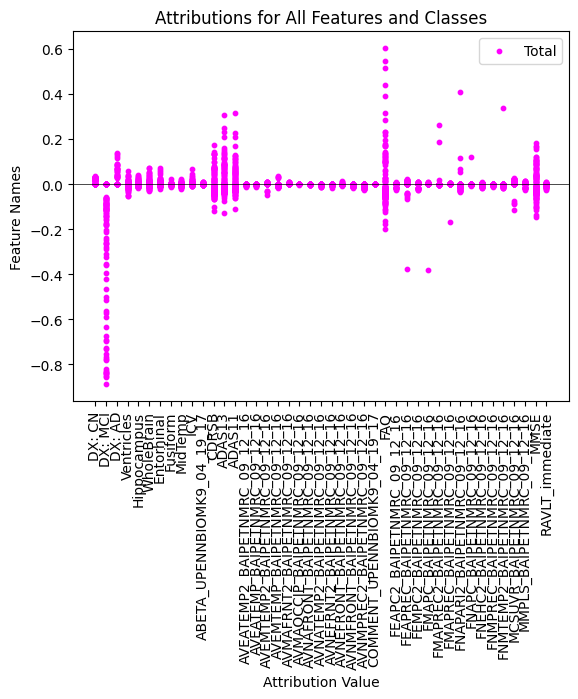

In [55]:
feature_names = misc.load_feature('data/features')
dx_names = ['CN', 'MCI', 'AD']
feature_names = ['DX: CN', 'DX: MCI', 'DX: AD'] + feature_names

colors = ['blue', 'red', 'green']
plot_violin(divided_attributions, feature_names, colors, -2)

number of features: 43


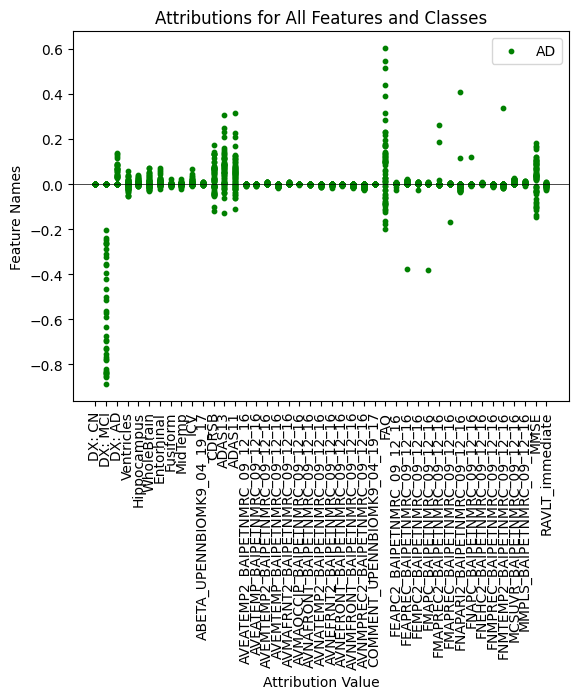

In [56]:
feature_names = misc.load_feature('data/features')
dx_names = ['CN', 'MCI', 'AD']
feature_names = ['DX: CN', 'DX: MCI', 'DX: AD'] + feature_names

plot_violin(divided_attributions, feature_names, colors, 2)

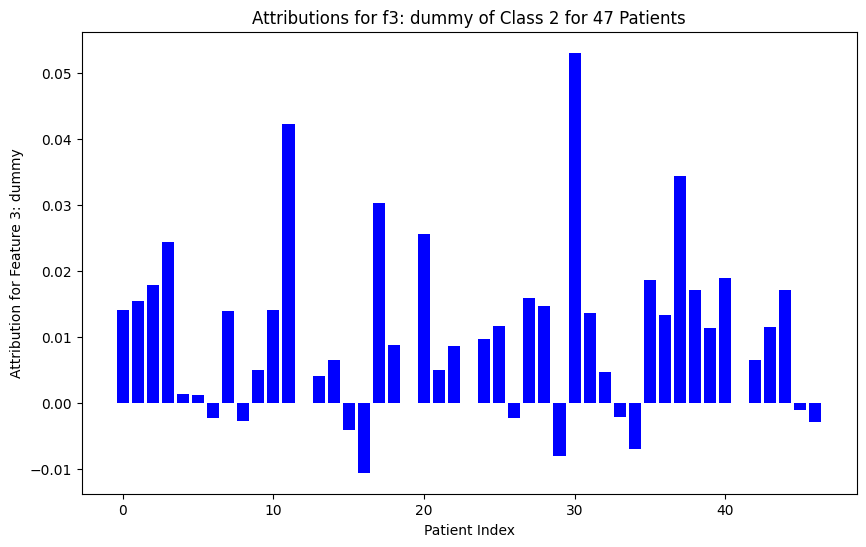

In [31]:
import matplotlib.pyplot as plt

def plot_feature_attributions(feature_index, num_patients, class_index, 
                              divided_attributions, feature_name, isShow=True):
    # Extract attributions for the specified class index and feature index
    attributions = divided_attributions[class_index]

    if num_patients == -1:
        num_patients = len(attributions)

    # Extract the feature attributions for the specified feature index
    feature_attributions = [attribution['attribution_data']['cat'][1][0][0][feature_index].numpy() for attribution in attributions[:num_patients]]

    feature_mean = np.mean(feature_attributions)
    feature_std = np.std(feature_attributions)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    for i, attribution in enumerate(feature_attributions):
        plt.bar(i, attribution, color='blue')
    plt.xlabel('Patient Index')
    plt.ylabel(f'Attribution for Feature {feature_index}: {feature_name}')
    plt.title(f'Attributions for f{feature_index}: {feature_name} of Class {class_index} for {num_patients} Patients')
    
    if isShow:
        plt.show()
    
    plt.savefig(f'MyData_42_feat/plots/{loaded_duration}/target_{loaded_target_index_2}/attr_C{class_index}_f{feature_index}.png')
    
    return feature_mean, feature_std

# Example usage
feature_index = 3  # Change this to the desired feature index
num_patients = -1  # Change this to -1 to include all patients, otherwise specify a number
class_index = 2  # Change this to the desired class index

feature_mean, feature_std = \
    plot_feature_attributions(feature_index, num_patients, \
        class_index, divided_attributions, "dummy", False)


### Combined attempt

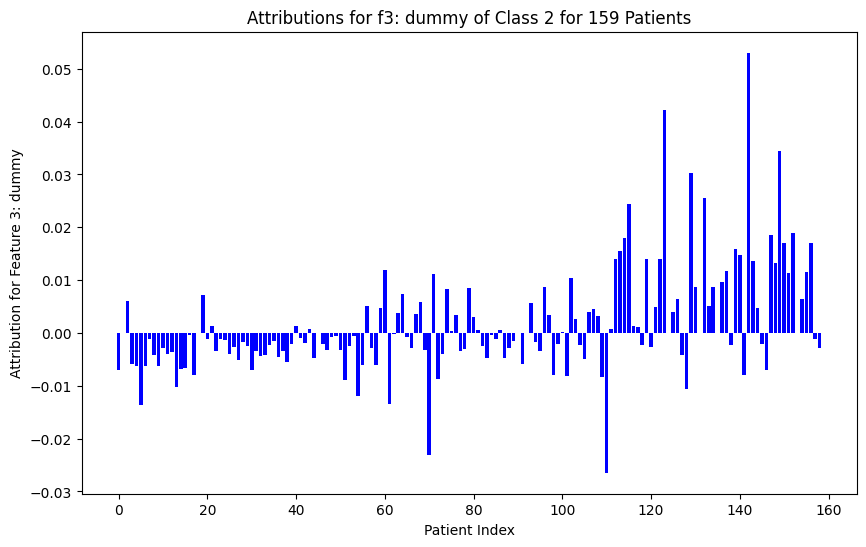

In [32]:
import matplotlib.pyplot as plt

def plot_feature_attributions2(feature_index, num_patients, class_index, 
                               attributions, feature_name, isShow=True):
    # Extract attributions for the specified class index and feature index
    attributions0 = divided_attributions[0]
    attributions1 = divided_attributions[1]
    attributions2 = divided_attributions[2]
    
    #concat 3 lists
    attributions = attributions0 + attributions1 + attributions2

    if num_patients == -1:
        num_patients = len(attributions)

    # Extract the feature attributions for the specified feature index
    feature_attributions = [attribution['attribution_data']['cat'][1][0][0][feature_index].numpy() for attribution in attributions[:num_patients]]

    feature_mean = np.mean(feature_attributions)
    feature_std = np.std(feature_attributions)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    for i, attribution in enumerate(feature_attributions):
        plt.bar(i, attribution, color='blue')
    plt.xlabel('Patient Index')
    plt.ylabel(f'Attribution for Feature {feature_index}: {feature_name}')
    plt.title(f'Attributions for f{feature_index}: {feature_name} of Class {class_index} for {num_patients} Patients')
    
    if isShow:
        plt.show()
        
    #save fig
    plt.savefig(f'MyData_42_feat/plots/{loaded_duration}/target_{loaded_target_index_2}/attr_all_f{feature_index}.png')
    
    return feature_mean, feature_std

# Example usage
feature_index = 3  # Change this to the desired feature index
num_patients = -1  # Change this to -1 to include all patients, otherwise specify a number
class_index = 2  # Change this to the desired class index

feature_mean, feature_std = \
    plot_feature_attributions2(feature_index, num_patients, \
        class_index, divided_attributions, "dummy", False)

### detailed analysis

In [ ]:
durations = [12, 24, 36]
categories = [0, 1, 2]

for duration in durations:
    loaded_duration = duration
    for c in categories:
        print(f"Duration: {duration}")
        print(f"Category: {c}")
        target_index_2 = c
        loaded_target_index_2 = target_index_2
        
        #load attributions
        with open(f'MyData_42_feat/attr2/attributions_{duration}_{target_index_2}.pickle', 'rb') as pickle_file:
            my_dict = pickle.load(pickle_file)
        
        #load ret
        with open(f'MyData_42_feat/ret2/ret_{duration}_{target_index_2}.pickle', 'rb') as pickle_file:
            ret = pickle.load(pickle_file)
            
        #divide data
        divided_ret, divided_attributions = divide_data_by_max_probability(ret, my_dict, duration)
        
        for class_index, data_list in divided_ret.items():
            print(f"Class {class_index}: {len(data_list)} patients")
            
        for class_index, data_list in divided_attributions.items():
            print(f"Class {class_index}: {len(data_list)} attributions")
            
        mean_values_CN = []
        mean_values_MCI = []    
        mean_values_AD = []

        mean_values_all = []

        std_values_CN = []
        std_values_MCI = []
        std_values_AD = []

        std_values_all = []

        num_features = 40
        num_patients = -1
        
        #list the feature names, means and stds
        feature_names = misc.load_feature('data/features')
        dx_names = ['CN', 'MCI', 'AD']
        
        for i in range(0, 3):
            feature_mean, feature_std = \
                plot_dx_attributions(i, num_patients, \
                    0, divided_attributions, dx_names[i], False)
            mean_values_CN.append(feature_mean)
            std_values_CN.append(feature_std)
            
            feature_mean, feature_std = \
                plot_dx_attributions(i, num_patients, \
                    1, divided_attributions, dx_names[i], False)
            mean_values_MCI.append(feature_mean)
            std_values_MCI.append(feature_std)
            
            feature_mean, feature_std = \
                plot_dx_attributions(i, num_patients, \
                    2, divided_attributions, dx_names[i], False)
            mean_values_AD.append(feature_mean)
            std_values_AD.append(feature_std)
            
            feature_mean, feature_std = \
                plot_dx_attributions_all(i, num_patients, \
                    0, divided_attributions, dx_names[i], False)
            mean_values_all.append(feature_mean)
            std_values_all.append(feature_std)

        for i in range(0, num_features):
            feature_mean, feature_std = \
                plot_feature_attributions(i, num_patients, \
                    0, divided_attributions, feature_names[i], False)
            mean_values_CN.append(feature_mean)
            std_values_CN.append(feature_std)
            
            feature_mean, feature_std = \
                plot_feature_attributions(i, num_patients, \
                    1, divided_attributions, feature_names[i], False)
            mean_values_MCI.append(feature_mean)
            std_values_MCI.append(feature_std)
            
            feature_mean, feature_std = \
                plot_feature_attributions(i, num_patients, \
                    2, divided_attributions, feature_names[i], False)
            mean_values_AD.append(feature_mean)
            std_values_AD.append(feature_std)
            
            feature_mean, feature_std = \
                plot_feature_attributions2(i, num_patients, \
                    0, divided_attributions, feature_names[i], False)
            mean_values_all.append(feature_mean)
            std_values_all.append(feature_std)
            
        
        # save the feature names, means and stds as a csv
        import csv
        
        dx_names = ['CN', 'MCI', 'AD']
        # append these names to feature_names
        feature_names = ['DX: CN', 'DX: MCI', 'DX: AD'] + feature_names

        with open(f'MyData_42_feat/plots/{loaded_duration}/target_{loaded_target_index_2}/all_attributions.csv', mode='w') as file:
            writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['Feature Name', 'CN Mean', 'CN Std', 
                            'MCI Mean', 'MCI Std', 'AD Mean', 'AD Std', 'Combined Mean', 'Combined Std'])
            for i in range(0, 43):
                writer.writerow([feature_names[i], mean_values_CN[i], std_values_CN[i], 
                                mean_values_MCI[i], std_values_MCI[i], mean_values_AD[i], 
                                std_values_AD[i], mean_values_all[i], std_values_all[i]])
                    

In [17]:
#list the feature names, means and stds
feature_names = misc.load_feature('data/features')
len(feature_names)

40

### Top 5 listing

In [20]:
#load the csv
import pandas as pd

loaded_csv_duration = 24
loaded_csv_target_index_2 = 2


df = pd.read_csv(f'MyData_42_feat/plots/{loaded_csv_duration}/target_{loaded_csv_target_index_2}/all_attributions.csv')
df.head()


# list the top 5 and bottom 5 features for each class only two related columns feature name and related mean
top_5_CN = df.nlargest(5, 'CN Mean')[['Feature Name', 'CN Mean']]
bottom_5_CN = df.nsmallest(5, 'CN Mean')[['Feature Name', 'CN Mean']]

top_5_MCI = df.nlargest(5, 'MCI Mean')[['Feature Name', 'MCI Mean']]
bottom_5_MCI = df.nsmallest(5, 'MCI Mean')[['Feature Name', 'MCI Mean']]

top_5_AD = df.nlargest(5, 'AD Mean')[['Feature Name', 'AD Mean']]
bottom_5_AD = df.nsmallest(5, 'AD Mean')[['Feature Name', 'AD Mean']]

top_5_all = df.nlargest(5, 'Combined Mean')[['Feature Name', 'Combined Mean']]
bottom_5_all = df.nsmallest(5, 'Combined Mean')[['Feature Name', 'Combined Mean']]


In [15]:
#top_5_CN
#top_5_MCI
top_5_AD

,Feature Name,AD Mean
10,RAVLT_perc_forgetting,0.036694
5,ADAS13,0.027042
8,RAVLT_learning,0.022109
16,ICV,0.020652
2,DX: AD,0.018284


In [21]:
#top_5_CN
#top_5_MCI
top_5_AD

,Feature Name,AD Mean
11,ADAS11,0.075535
2,DX: AD,0.050415
10,ABETA_UPENNBIOMK9_04_19_17,0.014387
8,MidTemp,0.011081
6,Entorhinal,0.009925


### Heatmap

In [57]:
# heatmap: feature attributions vs duration for a specific class, columns will be different durations
import seaborn as sns
import matplotlib.pyplot as plt

#load the csv
import pandas as pd

def heatmap_data(target_class, col_name):
    loaded_csv_duration = 24
    loaded_csv_target_index_2 = target_class
    cols = ['Feature Name', col_name]


    df1 = pd.read_csv(f'MyData_42_feat/plots/12/target_{loaded_csv_target_index_2}/all_attributions.csv')
    df2 = pd.read_csv(f'MyData_42_feat/plots/24/target_{loaded_csv_target_index_2}/all_attributions.csv')
    df3 = pd.read_csv(f'MyData_42_feat/plots/36/target_{loaded_csv_target_index_2}/all_attributions.csv')
    #df4 = pd.read_csv(f'MyData_42_feat/plots/80/target_{loaded_csv_target_index_2}/all_attributions.csv')

    data1 = df1[cols]
    data2 = df2[cols]
    data3 = df3[cols]
    #data4 = df4[cols]

    data1 = data1.set_index('Feature Name')
    data2 = data2.set_index('Feature Name')
    data3 = data3.set_index('Feature Name')
    #data4 = data4.set_index('Feature Name')

    durations = [12, 24, 36]
    # create a heatmap columns will be for data1, data2, data3, data4
    data = pd.concat([data1, data2, data3], axis=1)
    data.columns = durations
    
    return data


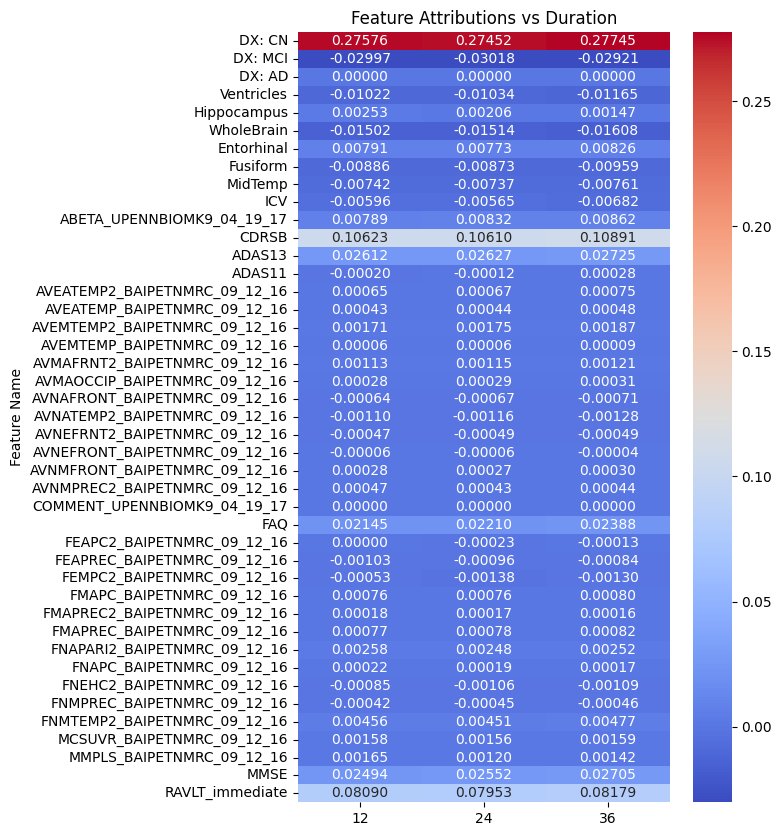

In [75]:
data = heatmap_data(0, 'CN Mean')


dx_features = ['DX: CN', 'DX: MCI', 'DX: AD']
#drop dx features
#data = data.drop(dx_features)

# drop some top features
#data = data.drop('CDRSB')
#data = data.drop('MMSE')
#data = data.drop('FAQ')

#drop specific feature from the data (for MCI)
#data = data.drop('DX: MCI')

#CN
#data = data.loc[['DX: MCI', 'CDRSB', 'FAQ', 'RAVLT_immediate']]

#MCI
#data = data.loc[['MMSE', 'CDRSB', 'RAVLT_immediate', 'FAQ', 'Fusiform']]

#AD
#data = data.loc[['ADAS13', 'ADAS11', 'MMSE', 'CDRSB', 'RAVLT_immediate', 'FAQ', 'ICV' , 'ABETA_UPENNBIOMK9_04_19_17']]

plt.figure(figsize=(6, 10))


#plt.figure(figsize=(8, 10))

# different colormap to differentiate more between positive and negative values
sns.heatmap(data, cmap='coolwarm', annot=True, fmt=".5f")
plt.title('Feature Attributions vs Duration')
plt.show()

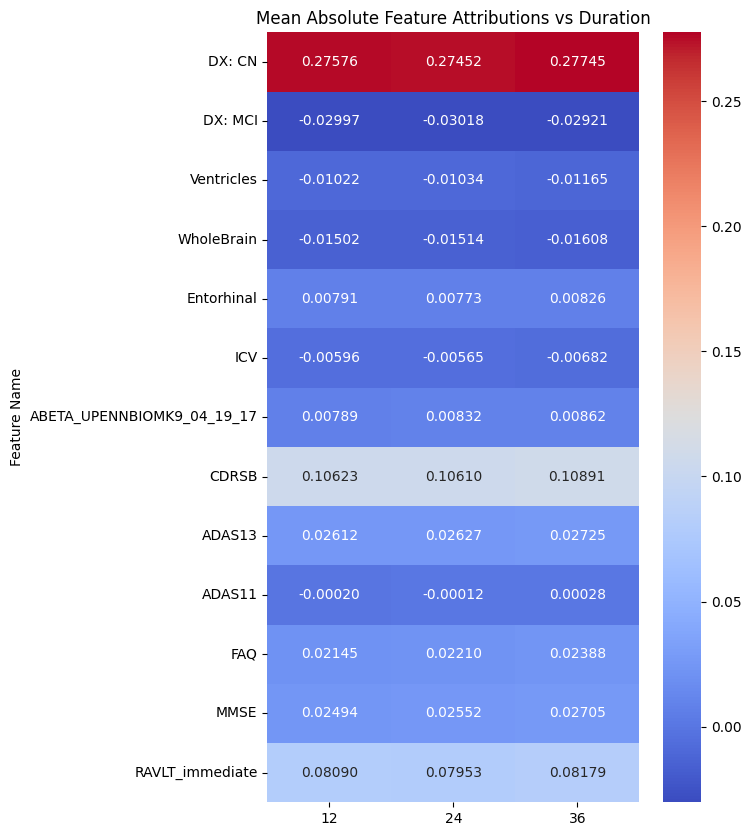

In [76]:
# taking the absolute values 
#data = data.abs()

# also discarding some very low values
#data = data[data > 0.001]

#discard specific rows by  range of index numbers

#CN
data = data.drop(data.index[28:41])
data = data.drop(data.index[14:27])
# data = data.drop(data.index[6])
data = data.drop(data.index[7:9])
data = data.drop(data.index[4])
data = data.drop(data.index[2])

#MCI
# data = data.drop(data.index[12:25])
# data = data.drop(data.index[10])
# data = data.drop(data.index[8])
# data = data.drop(data.index[3])
# data = data.drop(data.index[1])

#AD
# data = data.drop(data.index[1])
# data = data.drop(data.index[11])
# data = data.drop(data.index[8])
# data = data.drop(data.index[10:13])
# data = data.drop(data.index[9])
# data = data.drop(data.index[0])
# data = data.drop(data.index[11:17])

plt.figure(figsize=(6, 10))

# different colormap to differentiate more between positive and negative values
sns.heatmap(data, cmap='coolwarm', annot=True, fmt=".5f")
plt.title('Mean Absolute Feature Attributions vs Duration')
plt.show()


### Top features saved as txt file

In [ ]:
# print the feature and only their means for each class in a text file
with open(f'MyData_42_feat/plots/{loaded_csv_duration}/target_{loaded_csv_target_index_2}/top_bottom_features.txt', 'w') as f:
    f.write("Top 5 CN Features\n")
    f.write(top_5_CN.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 CN Features\n")
    f.write(bottom_5_CN.to_string())
    f.write("\n\n")
    
    f.write("Top 5 MCI Features\n")
    f.write(top_5_MCI.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 MCI Features\n")
    f.write(bottom_5_MCI.to_string())
    f.write("\n\n")
    
    f.write("Top 5 AD Features\n")
    f.write(top_5_AD.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 AD Features\n")
    f.write(bottom_5_AD.to_string())
    f.write("\n\n")
    
    f.write("Top 5 All Features\n")
    f.write(top_5_all.to_string())
    f.write("\n\n")
    
    f.write("Bottom 5 All Features\n")
    f.write(bottom_5_all.to_string())
    f.write("\n\n")


In [34]:
import matplotlib.pyplot as plt

# horizontal subplots
def plot_features_all_durations(target_class, topORbot):
    #load csv
    df1 = pd.read_csv(f'MyData_42_feat/plots/12/target_{target_class}/all_attributions.csv')
    df2 = pd.read_csv(f'MyData_42_feat/plots/24/target_{target_class}/all_attributions.csv')
    df3 = pd.read_csv(f'MyData_42_feat/plots/36/target_{target_class}/all_attributions.csv')
    #df4 = pd.read_csv(f'MyData_42_feat/plots/80/target_{target_class}/all_attributions.csv')
    
    if target_class == 0:
        target_class_name = 'CN'
    elif target_class == 1:
        target_class_name = 'MCI'
    else:
        target_class_name = 'AD'
    
    # data
    top_1 = df1.nlargest(7, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']] 
    top_2 = df2.nlargest(7, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    top_3 = df3.nlargest(7, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    #top_4 = df4.nlargest(7, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    
    bottom_1 = df1.nsmallest(7, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    bottom_2 = df2.nsmallest(7, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    bottom_3 = df3.nsmallest(7, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    #bottom_4 = df4.nsmallest(7, f'{target_class_name} Mean')[['Feature Name', f'{target_class_name} Mean']]
    
    # plot with error bars
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
        
    top_1_sorted = top_1.sort_values(by=f'{target_class_name} Mean', ascending=True)
    bottom_1_sorted = bottom_1.sort_values(by=f'{target_class_name} Mean', ascending=False)
    top_2_sorted = top_2.sort_values(by=f'{target_class_name} Mean', ascending=True)
    bottom_2_sorted = bottom_2.sort_values(by=f'{target_class_name} Mean', ascending=False)
    top_3_sorted = top_3.sort_values(by=f'{target_class_name} Mean', ascending=True)
    bottom_3_sorted = bottom_3.sort_values(by=f'{target_class_name} Mean', ascending=False)
    top_4_sorted = top_3.sort_values(by=f'{target_class_name} Mean', ascending=True)
    bottom_4_sorted = bottom_3.sort_values(by=f'{target_class_name} Mean', ascending=False)
    
    
    if topORbot == 'top':
        axs[0, 0].barh(top_1_sorted['Feature Name'], top_1_sorted[f'{target_class_name} Mean'], color='blue')
        axs[0, 0].set_title('Top Positively Attributed Features - 20 Months')
        axs[0, 0].set_xlabel('Mean Attribution')
        #axs[0, 0].set_ylabel('Feature Name')
        
        axs[0, 1].barh(top_2_sorted['Feature Name'], top_2_sorted[f'{target_class_name} Mean'], color='blue')
        axs[0, 1].set_title('Top Positively Attributed Features - 40 Months')
        axs[0, 1].set_xlabel('Mean Attribution')
        #axs[0, 1].set_ylabel('Feature Name')
        
        axs[1, 0].barh(top_3_sorted['Feature Name'], top_3_sorted[f'{target_class_name} Mean'], color='blue')
        axs[1, 0].set_title('Top Positively Attributed Features - 60 Months')
        axs[1, 0].set_xlabel('Mean Attribution')
        #axs[1, 0].set_ylabel('Feature Name')
        
        axs[1, 1].barh(top_4_sorted['Feature Name'], top_4_sorted[f'{target_class_name} Mean'], color='blue')
        axs[1, 1].set_title('Top Positively Attributed Features - 80 Months')
        axs[1, 1].set_xlabel('Mean Attribution')
        #axs[1, 1].set_ylabel('Feature Name')
    
    else:
        axs[0, 0].barh(bottom_1_sorted['Feature Name'], bottom_1_sorted[f'{target_class_name} Mean'], color='blue')
        axs[0, 0].set_title('Top Negatively Attributed Features - 20 Months')
        axs[0, 0].set_xlabel('Mean Attribution')
        #axs[0, 0].set_ylabel('Feature Name')
        
        axs[0, 1].barh(bottom_2_sorted['Feature Name'], bottom_2_sorted[f'{target_class_name} Mean'], color='blue')
        axs[0, 1].set_title('Top Negatively Attributed Features - 40 Months')
        axs[0, 1].set_xlabel('Mean Attribution')
        #axs[1, 1].set_ylabel('Feature Name')
        
        axs[1, 0].barh(bottom_3_sorted['Feature Name'], bottom_3_sorted[f'{target_class_name} Mean'], color='blue')
        axs[1, 0].set_title('Top Negatively Attributed Features - 60 Months')
        axs[1, 0].set_xlabel('Mean Attribution')
        #axs[1, 0].set_ylabel('Feature Name')
        
        axs[1, 1].barh(bottom_4_sorted['Feature Name'], bottom_4_sorted[f'{target_class_name} Mean'], color='blue')
        axs[1, 1].set_title('Top Negatively Attributed Features - 80 Months')
        axs[1, 1].set_xlabel('Mean Attribution')
        #axs[1, 1].set_ylabel('Feature Name')
        
    
    # axs[1, 0].barh(bottom_5_1_sorted['Feature Name'], bottom_5_1_sorted[f'{target_class_name} Mean'], color='blue')
    # axs[1, 0].set_title('Bottom 5 Features - 20 Days')
    # axs[1, 0].set_xlabel('Mean Attribution')
    # axs[1, 0].set_ylabel('Feature Name')
    
    # axs[1, 1].barh(bottom_5_2_sorted['Feature Name'], bottom_5_2_sorted[f'{target_class_name} Mean'], color='blue')
    # axs[1, 1].set_title('Bottom 5 Features - 40 Days')
    # axs[1, 1].set_xlabel('Mean Attribution')
    # #axs[1, 1].set_ylabel('Feature Name')
    
    # axs[1, 2].barh(bottom_5_3_sorted['Feature Name'], bottom_5_3_sorted[f'{target_class_name} Mean'], color='blue')
    # axs[1, 2].set_title('Bottom 5 Features - 60 Days')
    # axs[1, 2].set_xlabel('Mean Attribution')
    # #axs[1, 2].set_ylabel('Feature Name')
    
    # axs[1, 3].barh(bottom_5_4_sorted['Feature Name'], bottom_5_4_sorted[f'{target_class_name} Mean'], color='blue')
    # axs[1, 3].set_title('Bottom 5 Features - 80 Days')
    # axs[1, 3].set_xlabel('Mean Attribution')
    # axs[1, 3].set_ylabel('Feature Name')
    
    plt.tight_layout()
    #save plot in high resuolution
    plt.savefig(f'MyData_42_feat/plots/{topORbot}_features_{target_class_name}_v2.png')
    
    plt.show()
    
    
    

In [35]:
#plot the top and bottom features as horizontal bars
import matplotlib.pyplot as plt


def plot_absolute_feature_ranking(duration, target_class, dropDX=False):
    df = pd.read_csv(f'MyData_42_feat/plots/{duration}/target_{target_class}/all_attributions.csv')
    col = ''
    
    if target_class == 0:
        col = 'CN Mean'
    elif target_class == 1:
        col = 'MCI Mean'
    else:
        col = 'AD Mean'
        
    # take absolute value
    df[col] = df[col].abs()
    
    #drop rows with feature name containing DX
    if dropDX == True:
        df = df[~df['Feature Name'].str.contains('DX')]
    
    #sort the values
    all = df.sort_values(col, ascending=False)
    all = all[['Feature Name', col]]
    
    # plot the top and bottom features as horizontal bars, features in y axis, mean values in x axis
    fig, axs = plt.subplots(1, 1, figsize=(15, 10))
    
    all_sorted = all.sort_values(col, ascending=True)
    axs.barh(all_sorted['Feature Name'], all_sorted[col], color='blue')
    axs.set_xlabel('Mean Attribution')
    axs.set_title('All Features')
    
    plt.tight_layout()
    plt.show()
    
    
    

def plot_all_feature_rankings(duration, target_class):
    df = pd.read_csv(f'MyData_42_feat/plots/{duration}/target_{target_class}/feature_attributions.csv')
    
    # list all the top and bottom features for each class only two related columns feature name and related mean
    all_CN = df.nlargest(22, 'CN Mean')[['Feature Name', 'CN Mean']]
    all_MCI = df.nlargest(22, 'MCI Mean')[['Feature Name', 'MCI Mean']]
    all_AD = df.nlargest(22, 'AD Mean')[['Feature Name', 'AD Mean']]
    
    #plot the top and bottom features as horizontal bars, features in y axis, mean values in x axis
    fig, axs = plt.subplots(3, 1, figsize=(15, 10))
    
    all_CN_sorted = all_CN.sort_values('CN Mean', ascending=True)
    axs[0].barh(all_CN_sorted['Feature Name'], all_CN_sorted['CN Mean'], color='blue')
    axs[0].set_xlabel('Mean Attribution')
    axs[0].set_title('All CN Features')
    
    all_MCI_sorted = all_MCI.sort_values('MCI Mean', ascending=True)
    axs[1].barh(all_MCI_sorted['Feature Name'], all_MCI_sorted['MCI Mean'], color='blue')
    axs[1].set_xlabel('Mean Attribution')
    axs[1].set_title('All MCI Features')
    
    all_AD_sorted = all_AD.sort_values('AD Mean', ascending=True)
    axs[2].barh(all_AD_sorted['Feature Name'], all_AD_sorted['AD Mean'], color='blue')
    axs[2].set_xlabel('Mean Attribution')
    axs[2].set_title('All AD Features')
    
    plt.tight_layout()
    plt.show()
    
def plot_top_bottom_features(duration, target_class):
    
    #load csv
    df = pd.read_csv(f'MyData_42_feat/plots/{duration}/target_{target_class}/feature_attributions.csv')
    
    # list the top 5 and bottom 5 features for each class only two related columns feature name and related mean
    top_5_CN = df.nlargest(5, 'CN Mean')[['Feature Name', 'CN Mean']]
    bottom_5_CN = df.nsmallest(5, 'CN Mean')[['Feature Name', 'CN Mean']]

    top_5_MCI = df.nlargest(5, 'MCI Mean')[['Feature Name', 'MCI Mean']]
    bottom_5_MCI = df.nsmallest(5, 'MCI Mean')[['Feature Name', 'MCI Mean']]

    top_5_AD = df.nlargest(5, 'AD Mean')[['Feature Name', 'AD Mean']]
    bottom_5_AD = df.nsmallest(5, 'AD Mean')[['Feature Name', 'AD Mean']]

    top_5_all = df.nlargest(5, 'Combined Mean')[['Feature Name', 'Combined Mean']]
    bottom_5_all = df.nsmallest(5, 'Combined Mean')[['Feature Name', 'Combined Mean']]
    
    #print(bottom_5_CN)
    
    #plot the top and bottom features as horizontal bars, features in y axis, mean values in x axis
    fig, axs = plt.subplots(4, 2, figsize=(15, 10))
    
    top_5_CN_sorted = top_5_CN.sort_values('CN Mean', ascending=True)
    axs[0, 0].barh(top_5_CN_sorted['Feature Name'], top_5_CN_sorted['CN Mean'], color='blue')
    axs[0, 0].set_xlabel('Mean Attribution')
    axs[0, 0].set_title('Top 5 CN Features')
    
    bottom_5_CN_sorted = bottom_5_CN.sort_values('CN Mean', ascending=False)
    axs[0, 1].barh(bottom_5_CN_sorted['Feature Name'], bottom_5_CN_sorted['CN Mean'], color='blue')
    axs[0, 1].set_xlabel('Mean Attribution')
    axs[0, 1].set_title('Bottom 5 CN Features')
    
    top_5_MCI_sorted = top_5_MCI.sort_values('MCI Mean', ascending=True)
    axs[1, 0].barh(top_5_MCI_sorted['Feature Name'], top_5_MCI_sorted['MCI Mean'], color='blue')
    axs[1, 0].set_xlabel('Mean Attribution')
    axs[1, 0].set_title('Top 5 MCI Features')
    
    bottom_5_MCI_sorted = bottom_5_MCI.sort_values('MCI Mean', ascending=False)
    axs[1, 1].barh(bottom_5_MCI_sorted['Feature Name'], bottom_5_MCI_sorted['MCI Mean'], color='blue')
    axs[1, 1].set_xlabel('Mean Attribution')
    axs[1, 1].set_title('Bottom 5 MCI Features')
    
    top_5_AD_sorted = top_5_AD.sort_values('AD Mean', ascending=True)
    axs[2, 0].barh(top_5_AD_sorted['Feature Name'], top_5_AD_sorted['AD Mean'], color='blue')
    axs[2, 0].set_xlabel('Mean Attribution')
    axs[2, 0].set_title('Top 5 AD Features')
    
    bottom_5_AD_sorted = bottom_5_AD.sort_values('AD Mean', ascending=False)
    axs[2, 1].barh(bottom_5_AD_sorted['Feature Name'], bottom_5_AD_sorted['AD Mean'], color='blue')
    axs[2, 1].set_xlabel('Mean Attribution')
    axs[2, 1].set_title('Bottom 5 AD Features')
    
    top_5_all_sorted = top_5_all.sort_values('Combined Mean', ascending=True)
    axs[3, 0].barh(top_5_all_sorted['Feature Name'], top_5_all_sorted['Combined Mean'], color='blue')
    axs[3, 0].set_xlabel('Mean Attribution')
    axs[3, 0].set_title('Top 5 All Features')
    
    bottom_5_all_sorted = bottom_5_all.sort_values('Combined Mean', ascending=False)
    axs[3, 1].barh(bottom_5_all_sorted['Feature Name'], bottom_5_all_sorted['Combined Mean'], color='blue')
    axs[3, 1].set_xlabel('Mean Attribution')
    axs[3, 1].set_title('Bottom 5 All Features')
    
    plt.tight_layout()
    plt.show()


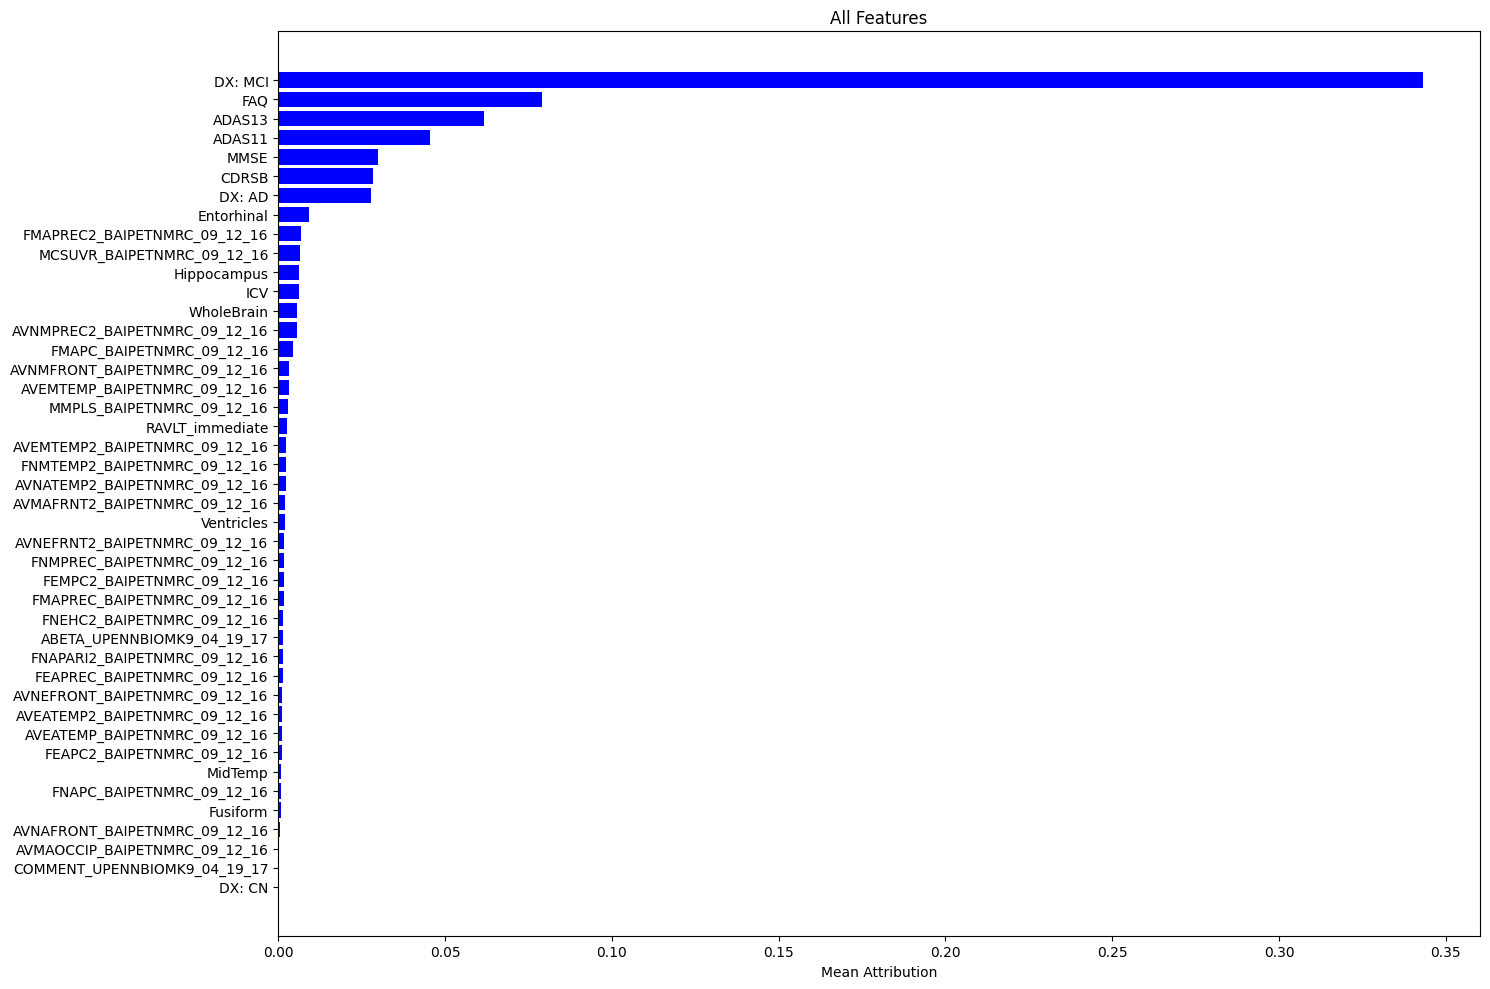

In [49]:
plot_absolute_feature_ranking(36, 2, False)

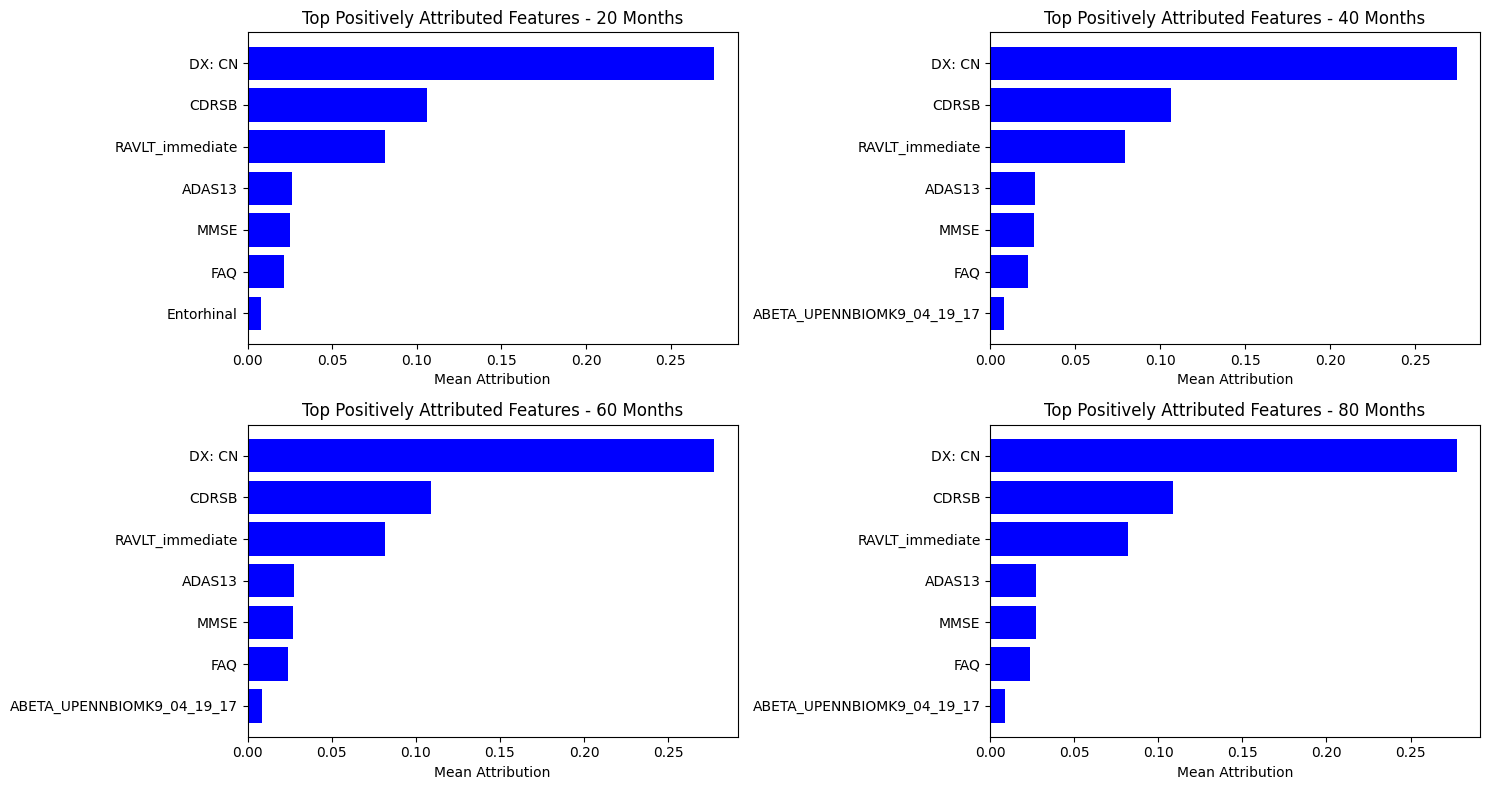

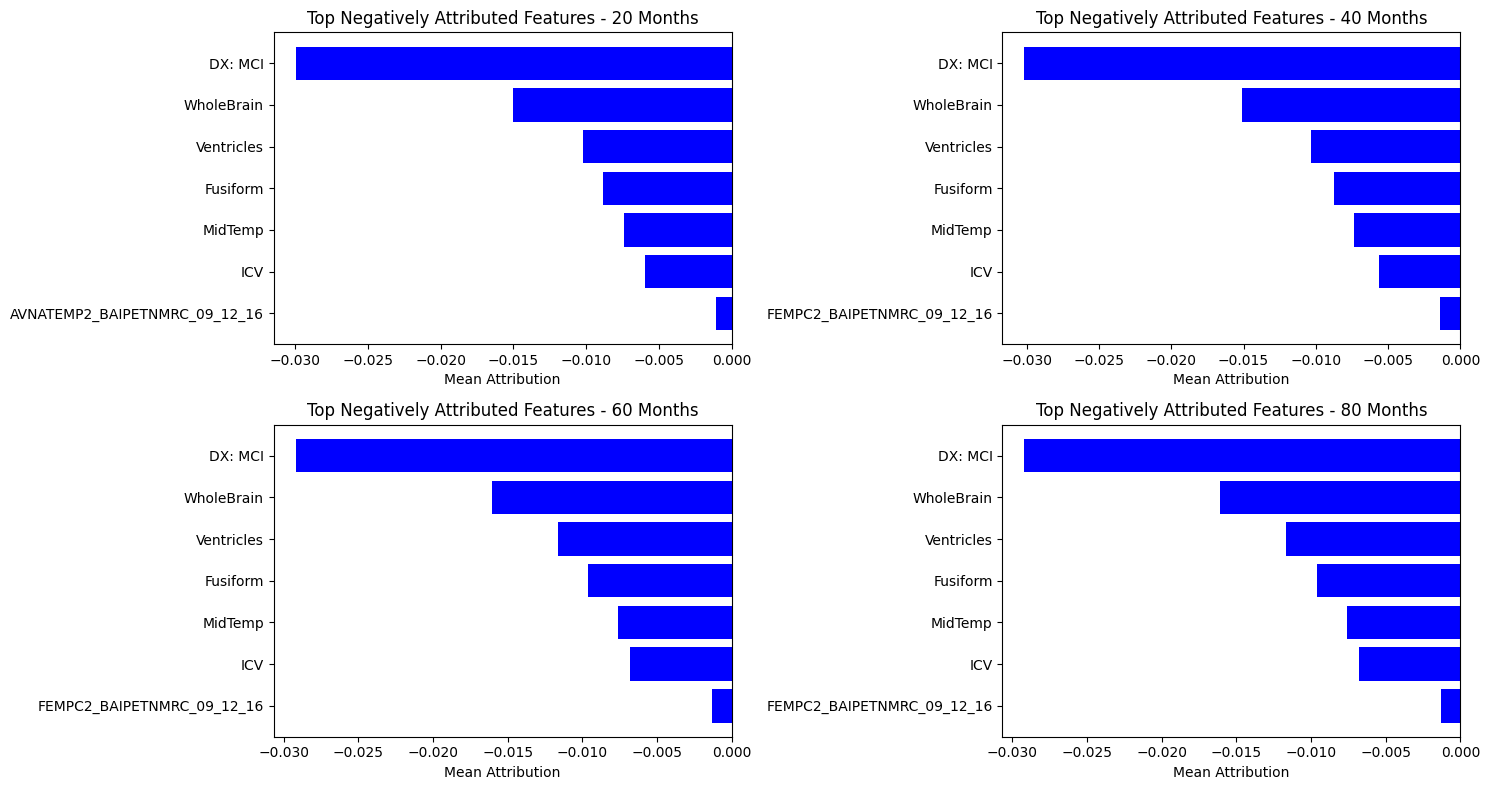

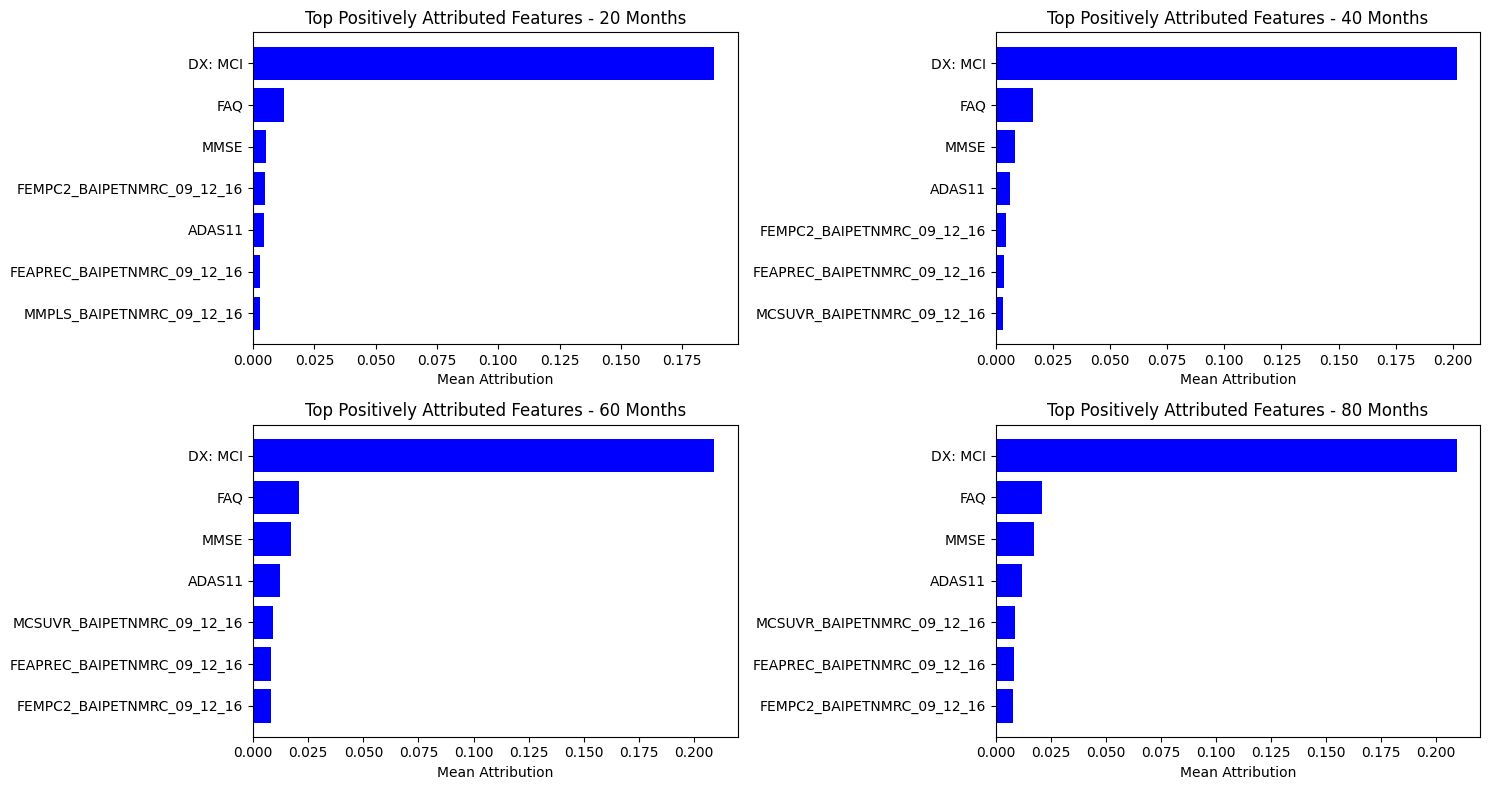

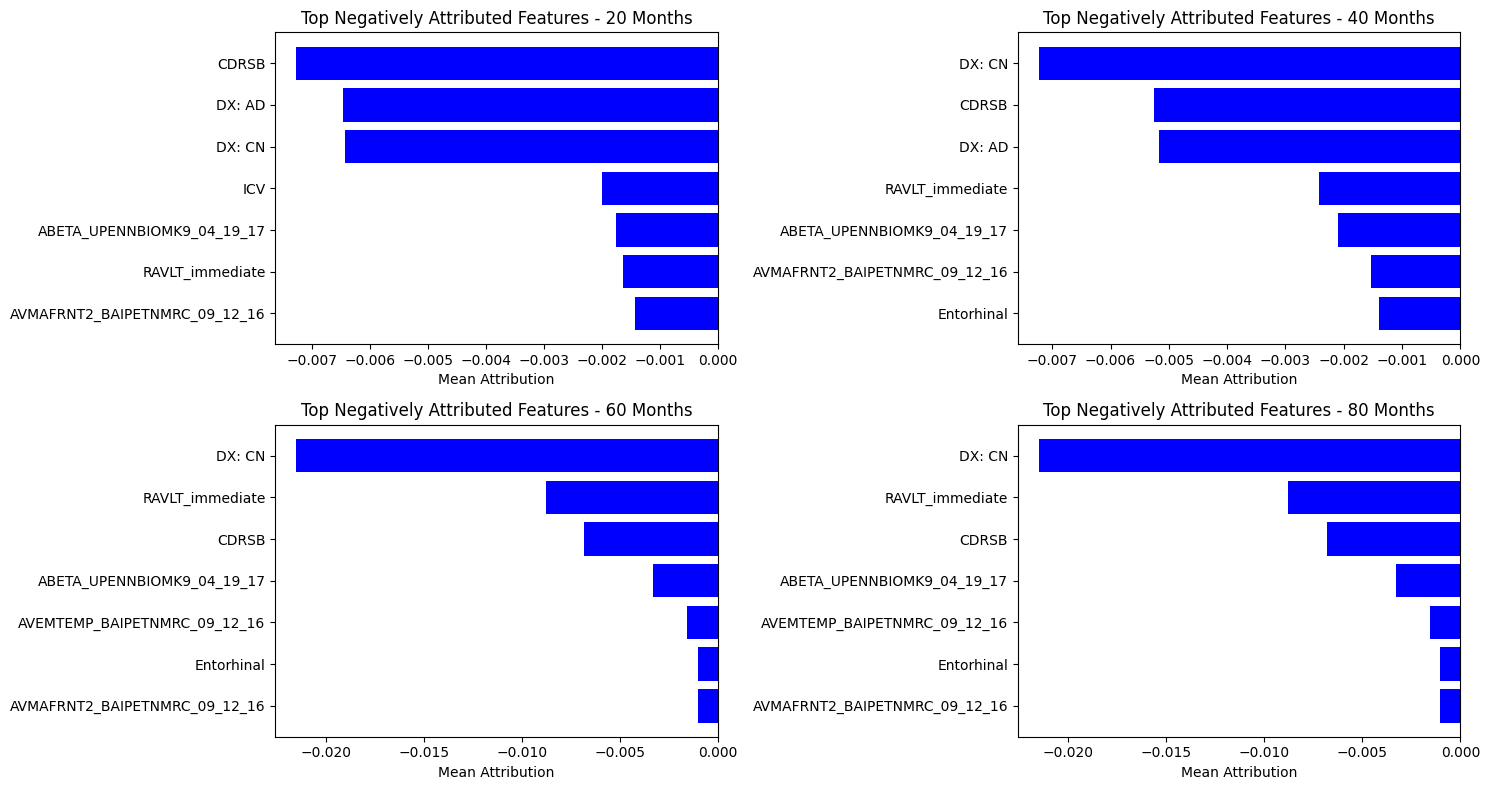

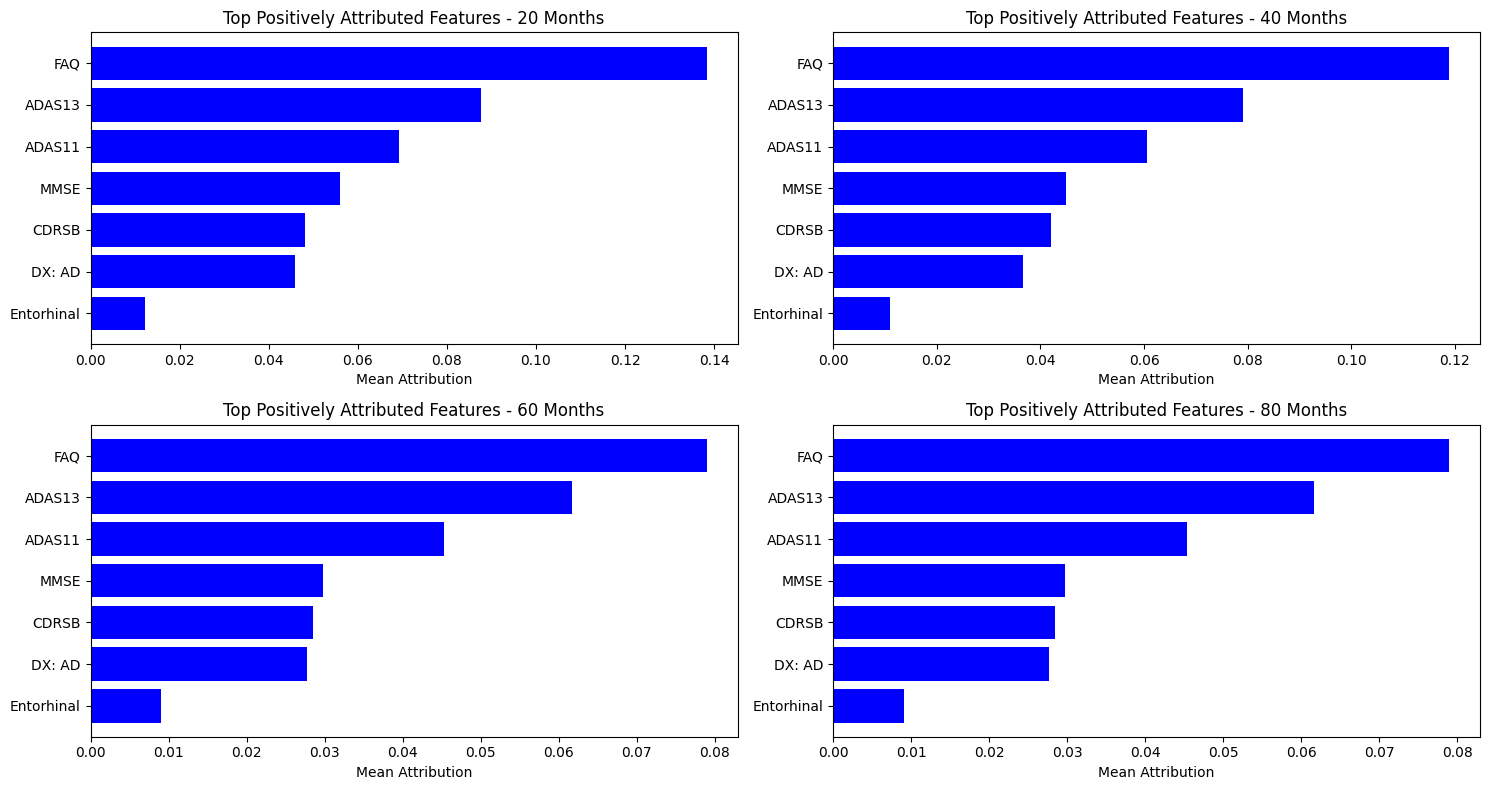

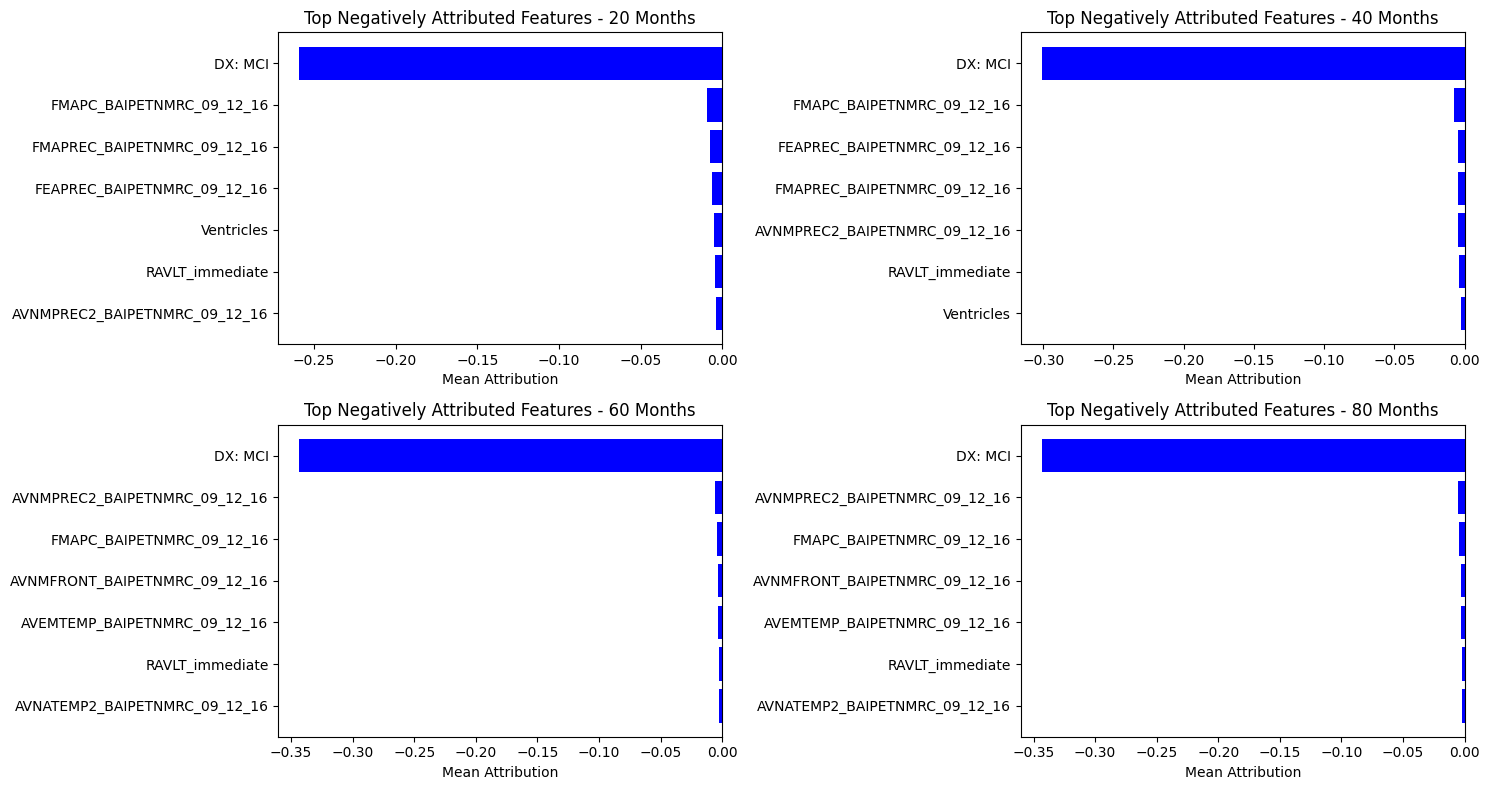

In [48]:
for i in range (0,3):
    plot_features_all_durations(i, 'top')
    plot_features_all_durations(i, 'bottom')

In [ ]:
plot_features_all_durations(0, 'top')

In [ ]:
plot_features_all_durations(0, 'bottom')

In [ ]:
#example usage
plot_top_bottom_features(80, 2)

In [ ]:
# sort by specific column values

target_column = 'CN Mean'
df = df.sort_values(by=[target_column], ascending=False)
df

In [146]:
df = df.sort_values(by=[target_column], ascending=True)
df

,Feature Name,CN Mean,CN Std,MCI Mean,MCI Std,AD Mean,AD Std,Combined Mean,Combined Std
9,FAQ,NaN,NaN,0.052298,0.063847,-0.070392,0.131400,0.016031,0.105402
2,ADAS13,NaN,NaN,0.010744,0.023819,-0.056371,0.054758,-0.009095,0.047158
0,CDRSB,NaN,NaN,0.034485,0.056518,-0.043007,0.083111,0.011578,0.074446
1,ADAS11,NaN,NaN,0.010079,0.014872,-0.029103,0.039646,-0.001503,0.030661
4,RAVLT_immediate,NaN,NaN,-0.001576,0.015098,-0.025331,0.026226,-0.008597,0.021941
7,RAVLT_perc_forgetting,NaN,NaN,-0.003381,0.022189,-0.024871,0.035294,-0.009733,0.028481
3,MMSE,NaN,NaN,0.026167,0.044368,-0.023246,0.067566,0.011561,0.056960
5,RAVLT_learning,NaN,NaN,-0.001524,0.013668,-0.018586,0.024872,-0.006568,0.019367
10,Entorhinal,NaN,NaN,0.000962,0.018497,-0.015247,0.022933,-0.003829,0.021240
13,ICV,NaN,NaN,-0.003125,0.015223,-0.012046,0.029644,-0.005762,0.020966


### Ranking of the feature attributions

In [ ]:
# sort the features by std deviation
import pandas as pd

# Create a dataframe
df = pd.DataFrame(list(zip(feature_names, mean_values_CN, std_values_CN, 
                           mean_values_MCI, std_values_MCI, mean_values_AD, 
                           std_values_AD, mean_values_all, std_values_all)), 
               columns =['Feature Name', 'CN Mean', 'CN Std', 'MCI Mean', 
                         'MCI Std', 'AD Mean', 'AD Std', 'Combined Mean', 'Combined Std'])

# Sort the dataframe by std deviation
df = df.sort_values(by='MCI Mean', ascending=True)

df


,Feature Name,CN Mean,CN Std,MCI Mean,MCI Std,AD Mean,AD Std,Combined Mean,Combined Std
9,FAQ,NaN,NaN,-2.441719e-03,0.002558,-0.003019,0.002934,-0.002612,0.002688
0,CDRSB,NaN,NaN,-1.785467e-03,0.001259,-0.002116,0.002317,-0.001883,0.001651
3,MMSE,NaN,NaN,-1.034284e-03,0.000834,-0.001204,0.001489,-0.001084,0.001073
2,ADAS13,NaN,NaN,-5.011546e-04,0.000488,-0.001571,0.001314,-0.000817,0.000957
1,ADAS11,NaN,NaN,-2.930287e-04,0.000330,-0.001445,0.001496,-0.000634,0.001007
18,FDG,NaN,NaN,-1.272887e-04,0.000283,-0.000243,0.000770,-0.000161,0.000484
13,ICV,NaN,NaN,-1.253471e-04,0.000603,-0.000502,0.001892,-0.000237,0.001159
10,Entorhinal,NaN,NaN,-1.101924e-04,0.000400,-0.000309,0.000455,-0.000169,0.000427
14,MidTemp,NaN,NaN,-1.064647e-04,0.000418,0.000121,0.000224,-0.000039,0.000386
11,Fusiform,NaN,NaN,-1.258037e-05,0.000139,0.000110,0.000201,0.000024,0.000169


In [ ]:
# Sort the dataframe by std deviation
df = df.sort_values(by='Combined Mean', ascending=False)

df

In [ ]:
# sort the features by std deviation
import pandas as pd

# Create a dataframe
df = pd.DataFrame(list(zip(feature_names, mean_values_CN, std_values_CN, mean_values_MCI, std_values_MCI, mean_values_AD, std_values_AD)), 
               columns =['Feature Name', 'CN Mean', 'CN Std', 'MCI Mean', 'MCI Std', 'AD Mean', 'AD Std'])

# Sort the dataframe by std deviation
df = df.sort_values(by='AD Mean', ascending=True)

df


,Feature Name,CN Mean,CN Std,MCI Mean,MCI Std,AD Mean,AD Std
9,FAQ,NaN,NaN,-2.441719e-03,0.002558,-0.003019,0.002934
0,CDRSB,NaN,NaN,-1.785467e-03,0.001259,-0.002116,0.002317
4,RAVLT_immediate,NaN,NaN,2.910694e-04,0.000730,-0.002005,0.001163
5,RAVLT_learning,NaN,NaN,2.805122e-04,0.001061,-0.001725,0.001523
2,ADAS13,NaN,NaN,-5.011546e-04,0.000488,-0.001571,0.001314
1,ADAS11,NaN,NaN,-2.930287e-04,0.000330,-0.001445,0.001496
7,RAVLT_perc_forgetting,NaN,NaN,1.868886e-04,0.000656,-0.001278,0.001736
19,ABETA_UPENNBIOMK9_04_19_17,NaN,NaN,4.457639e-04,0.001910,-0.001236,0.001358
3,MMSE,NaN,NaN,-1.034284e-03,0.000834,-0.001204,0.001489
12,Hippocampus,NaN,NaN,2.589545e-04,0.000681,-0.000699,0.001072


In [ ]:
# Plot the mean and standard deviation of the feature attributions
print(f'Mean of the feature attributions: {feature_mean}')
print(f'Standard deviation of the feature attributions: {feature_std}')


Mean of the feature attributions: 0.01653003559434911
Standard deviation of the feature attributions: 0.02750965793172113


In [ ]:
import pickle

my_dict = attributions

with open(f'MyData_42_feat/attributions_{duration}_{target_index_2}.pickle', 'wb') as pickle_file:
    pickle.dump(my_dict, pickle_file)
